In [1]:
from model.deeponet import *
import numpy as np
from src.collision_operator_HG_1D import CollisionOperatorHG1D
from src.collision_operator_HG_3D import CollisionOperatorHG3D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [2]:
gpu_id='3'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  3


## 1) 1D case with g=0.0

In [3]:
dimension=1
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    'HG_00_wo_bias',
    'HG_00_w_bias',
    'HG_00_soft_lamb01',
    'HG_00_hard_gram',
    'HG_00_hard_special'
]

In [4]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [5]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

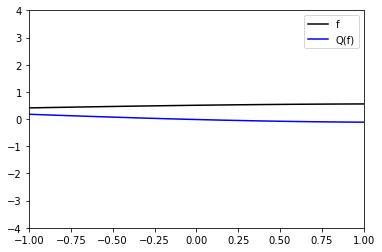

Volume is 1.0000001192092896


In [6]:
idx=np.random.randint(train_data_f.shape[0])
plt.plot(grid.cpu(), train_data_f[idx], 'k')
plt.plot(grid.cpu(), train_data_Q[idx], 'b')
plt.legend(["f", "Q(f)"])
plt.xlim(-1,1)
plt.ylim(-4,4)
plt.show()
print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [7]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

10000
tensor(0.0132)
9900
tensor(0.0146)
9700
tensor(0.0135)
9100
tensor(0.0084)
9900
tensor(0.0104)


In [8]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

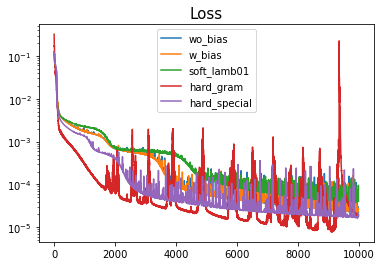

In [9]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

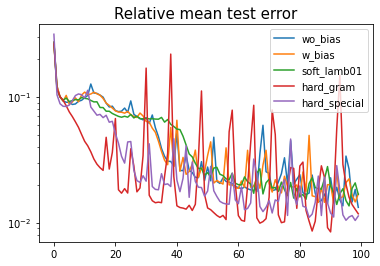

In [10]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [11]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

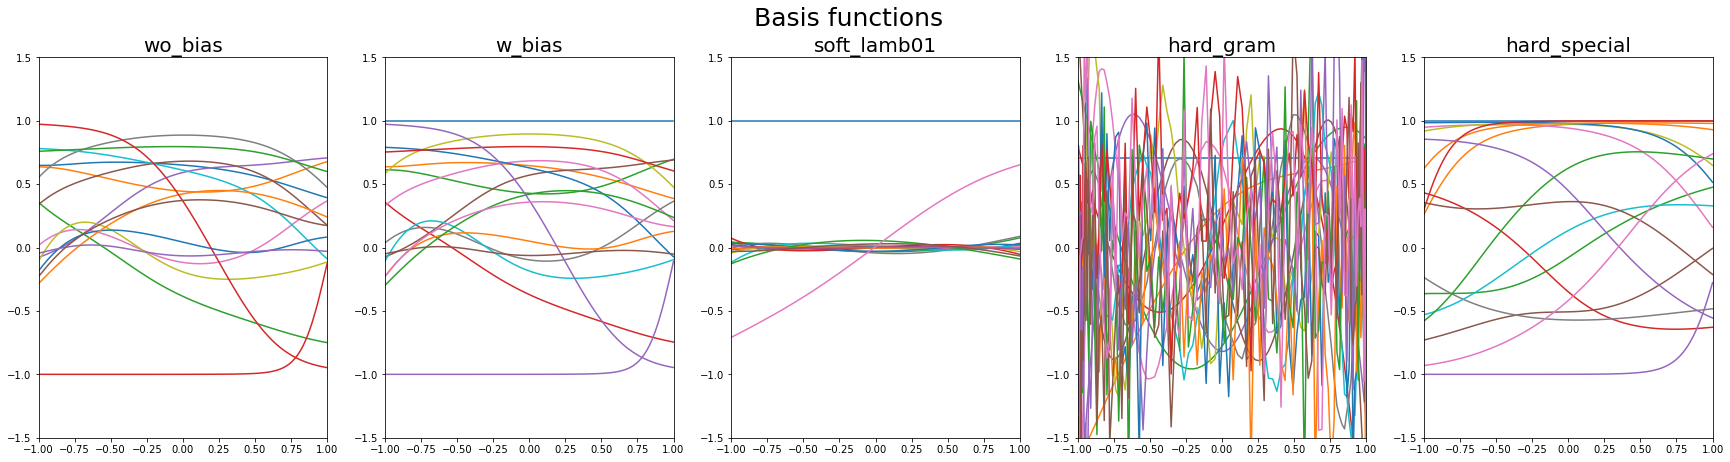

In [12]:
plt.figure(figsize=(30,7))
plt.suptitle(r'Basis functions', fontsize=25)
for idx in range(len(models)):
    ax=plt.subplot(1,len(models),idx+1)
    ax.set_title(names[idx], fontsize=20)
    for i in range(n_basiss[idx]):
        ax.plot(grid.detach().cpu(),all_basis[idx][i], label='{}-th basis'.format(i))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1.5,1.5)
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.show()

In [13]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

In [14]:
quad_w.shape

torch.Size([100])

wo_bias      test error=0.0132, Mean $\int Qdv$=8.52E-04
w_bias       test error=0.0146, Mean $\int Qdv$=1.05E-03
soft_lamb01  test error=0.0135, Mean $\int Qdv$=1.67E-03
hard_gram    test error=0.0084, Mean $\int Qdv$=3.94E-04
hard_special test error=0.0104, Mean $\int Qdv$=7.58E-08


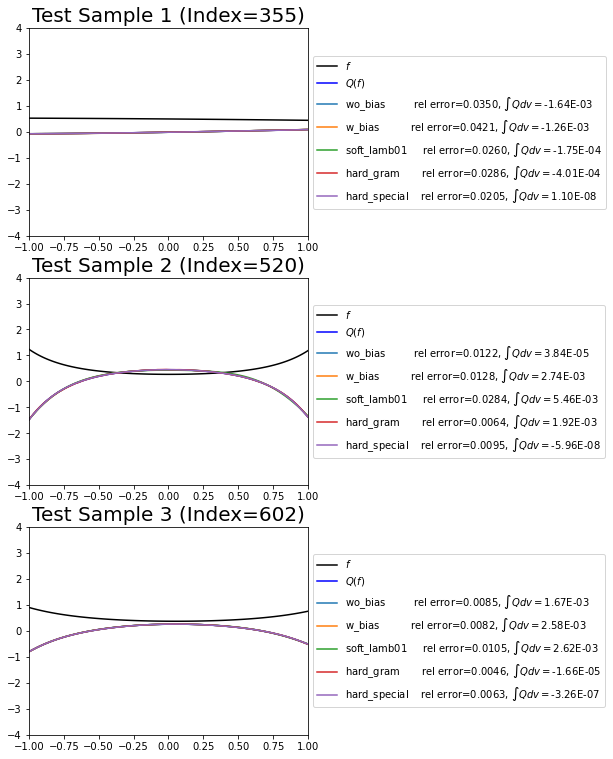

In [15]:
num_plot=3
plt.figure(figsize=(5,13))

for plot_idx in range(num_plot):
    ax=plt.subplot(num_plot,1,plot_idx+1)
    data_idx=np.random.randint(test_data_f.shape[0])
    ax.set_title("Test Sample {} (Index={})".format(str(plot_idx+1),data_idx), fontsize=20)
    ax.plot(grid.detach().cpu(), test_data_f[data_idx], '-k', label=r'$f$')
    ax.plot(grid.detach().cpu(), test_data_Q[data_idx], 'b', markersize=3, label=r'$Q(f)$')
    ax.set_xlim(-1,1)
    ax.set_ylim(-4,4)
    for idx in range(len(models)):
        prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
        ax.plot(grid.detach().cpu(), prediction, label=r"{:15s} rel error={:.4f}, $\int Q dv=${:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu())))
        if plot_idx==0:
            prediction_all=models[idx](test_data_f.unsqueeze(1).cuda(), grid).squeeze().detach().cpu()
            all_error=rel_L2_error(prediction_all, test_data_Q).mean()
            all_Qdv=torch.mean(torch.abs(torch.sum(prediction_all*quad_w.detach().cpu(), axis=-1)))
            print(r"{:12s} test error={:.4f}, Mean $\int Qdv$={:.2E}".format(names[idx],all_error, all_Qdv))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

## 2) 1D case with g=0.9

In [16]:
dimension=1
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    'HG_09_wo_bias',
    'HG_09_w_bias',
    'HG_09_soft_lamb01',
    'HG_09_hard_gram',
    'HG_09_hard_special'
]

In [17]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [18]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

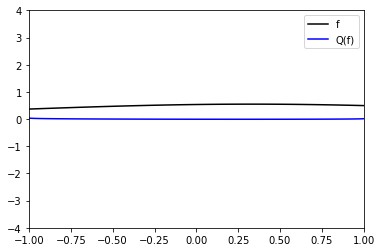

Volume is 1.0


In [19]:
idx=np.random.randint(train_data_f.shape[0])
plt.plot(grid.cpu(), train_data_f[idx], 'k')
plt.plot(grid.cpu(), train_data_Q[idx], 'b')
plt.legend(["f", "Q(f)"])
plt.xlim(-1,1)
plt.ylim(-4,4)
plt.show()
print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [20]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

10000
tensor(0.1064)
10000
tensor(0.1074)
9900
tensor(0.1771)
4400
tensor(0.1056)
10000
tensor(0.0425)


In [21]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

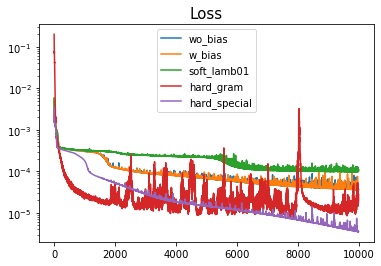

In [22]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

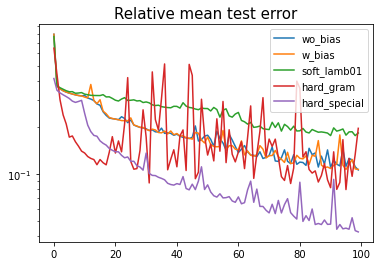

In [23]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [24]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

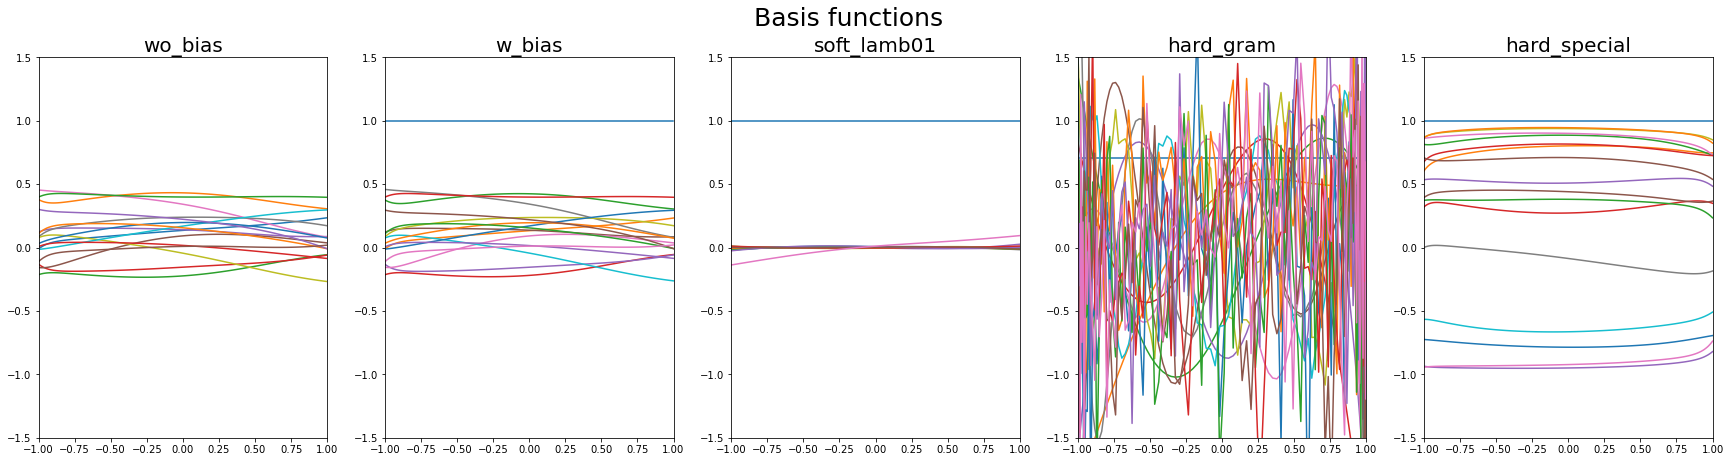

In [25]:
plt.figure(figsize=(30,7))
plt.suptitle(r'Basis functions', fontsize=25)
for idx in range(len(models)):
    ax=plt.subplot(1,len(models),idx+1)
    ax.set_title(names[idx], fontsize=20)
    for i in range(n_basiss[idx]):
        ax.plot(grid.detach().cpu(),all_basis[idx][i], label='{}-th basis'.format(i))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1.5,1.5)
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.show()

In [26]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

wo_bias      test error=0.1064, Mean $\int Qdv$=1.17E-03
w_bias       test error=0.1074, Mean $\int Qdv$=1.03E-03
soft_lamb01  test error=0.1771, Mean $\int Qdv$=1.58E-03
hard_gram    test error=0.1056, Mean $\int Qdv$=4.16E-04
hard_special test error=0.0425, Mean $\int Qdv$=7.62E-08


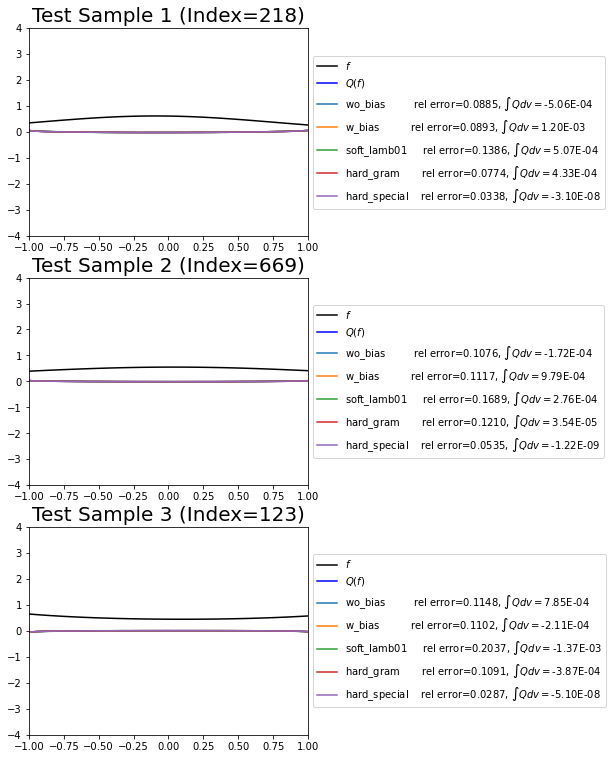

In [27]:
num_plot=3
plt.figure(figsize=(5,13))

for plot_idx in range(num_plot):
    ax=plt.subplot(num_plot,1,plot_idx+1)
    data_idx=np.random.randint(test_data_f.shape[0])
    ax.set_title("Test Sample {} (Index={})".format(str(plot_idx+1),data_idx), fontsize=20)
    ax.plot(grid.detach().cpu(), test_data_f[data_idx], '-k', label=r'$f$')
    ax.plot(grid.detach().cpu(), test_data_Q[data_idx], 'b', markersize=3, label=r'$Q(f)$')
    ax.set_xlim(-1,1)
    ax.set_ylim(-4,4)
    for idx in range(len(models)):
        prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
        ax.plot(grid.detach().cpu(), prediction, label=r"{:15s} rel error={:.4f}, $\int Q dv=${:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu())))
        if plot_idx==0:
            prediction_all=models[idx](test_data_f.unsqueeze(1).cuda(), grid).squeeze().detach().cpu()
            all_error=rel_L2_error(prediction_all, test_data_Q).mean()
            all_Qdv=torch.mean(torch.abs(torch.sum(prediction_all*quad_w.detach().cpu(), axis=-1)))
            print(r"{:12s} test error={:.4f}, Mean $\int Qdv$={:.2E}".format(names[idx],all_error, all_Qdv))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

## 3) 3D case with g=0.0

In [28]:
dimension=3
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    'HG_00_wo_bias',
    'HG_00_w_bias',
    'HG_00_soft_lamb01',
    'HG_00_hard_gram',
    'HG_00_hard_special'
]

In [29]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [30]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_test_data.npz')


train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

Volume is 0.9999999403953552


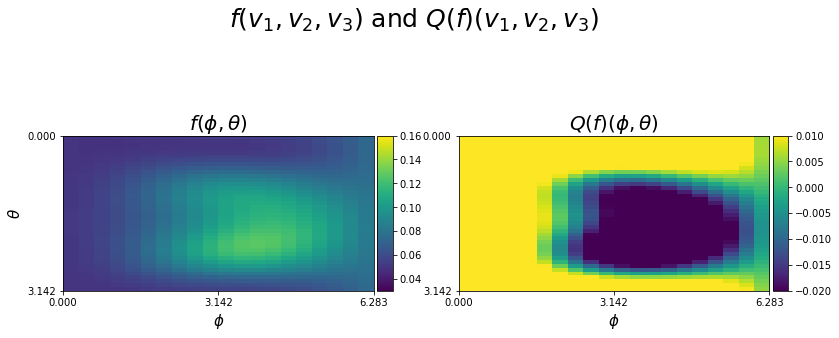

In [31]:
idx=np.random.randint(train_data_f.shape[0])

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig=plt.figure(figsize=(13,6))
plt.suptitle(r'$f(v_1,v_2,v_3)$ and $Q(f)(v_1,v_2,v_3)$', fontsize=25)
ax=plt.subplot(1,2,1)
ax.set_title(r'$f(\phi,\theta)$', fontsize=20)
im=ax.imshow(train_data_f[idx].reshape(integration_order*2,integration_order), vmin=0.03, vmax=0.16, extent=(0,2*np.pi,np.pi,0), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_ylabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

ax=plt.subplot(1,2,2)
ax.set_title(r'$Q(f)(\phi,\theta)$', fontsize=20)
im=ax.imshow(train_data_Q[idx].reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [32]:
print(torch.max(train_data_f),torch.min(train_data_f))

tensor(0.1699) tensor(0.0323)


In [33]:
print(torch.max(train_data_Q),torch.min(train_data_Q))

tensor(0.0473) tensor(-0.0903)


In [34]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

7600
tensor(0.1086)
3800
tensor(0.1123)
9600
tensor(0.1435)
7100


tensor(0.0710)
6800
tensor(0.1063)


In [35]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

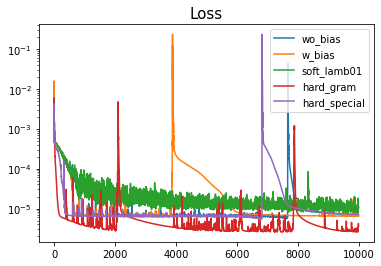

In [36]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

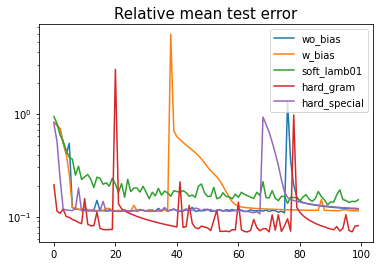

In [37]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [38]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

In [39]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

233
wo_bias      test error=0.1086, Mean $\int Qdv$=2.57E-03
(sample) test error=0.1044
w_bias       test error=0.1123, Mean $\int Qdv$=9.59E-04
(sample) test error=0.1072
soft_lamb01  test error=0.1435, Mean $\int Qdv$=1.44E-02
(sample) test error=0.1287
hard_gram    test error=0.0710, Mean $\int Qdv$=9.29E-08
(sample) test error=0.0702
hard_special test error=0.1063, Mean $\int Qdv$=1.11E-07
(sample) test error=0.1156


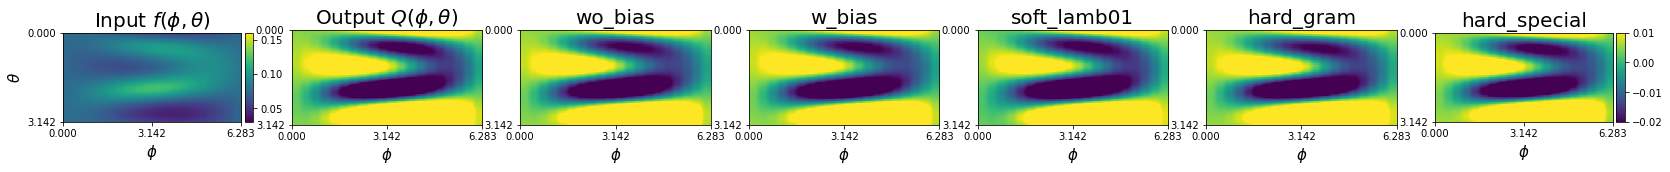

In [40]:
data_idx=np.random.randint(test_data_f.shape[0])
print(data_idx)
plt.figure(figsize=(28,5))

ax=plt.subplot(1,7,1)
ax.set_title(r"Input $f(\phi,\theta)$", fontsize=20)
im=ax.imshow(test_data_f[data_idx].reshape(integration_order*2,integration_order), vmin=0.03, vmax=0.16, extent=(0,2*np.pi,np.pi,0), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_ylabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

ax=plt.subplot(1,7,2)
ax.set_title(r"Output $Q(\phi,\theta)$", fontsize=20)
im=ax.imshow(test_data_Q[data_idx].reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

for idx in range(len(models)):
    ax=plt.subplot(1,7,idx+2+1)
    prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
    ax.set_title("{}".format(names[idx]), fontsize=20)
    im=ax.imshow(prediction.reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower')
    ax.set_xlabel(r'$\phi$',fontsize=15)
    ax.set_xticks([0,np.pi,2*np.pi])
    ax.set_yticks([0,np.pi])
    prediction_all=models[idx](test_data_f.unsqueeze(1).cuda(), grid).squeeze().detach().cpu()
    all_error=rel_L2_error(prediction_all, test_data_Q).mean()
    all_Qdv=torch.mean(torch.abs(torch.sum(prediction_all*quad_w.detach().cpu(), axis=-1)))
    print(r"{:12s} test error={:.4f}, Mean $\int Qdv$={:.2E}".format(names[idx],all_error, all_Qdv))
    
    print("(sample) test error={:.4f}".format(rel_L2_error(prediction, test_data_Q[data_idx])))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

#### Paper plot

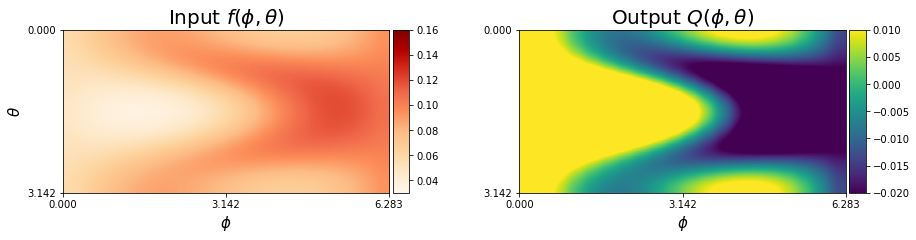

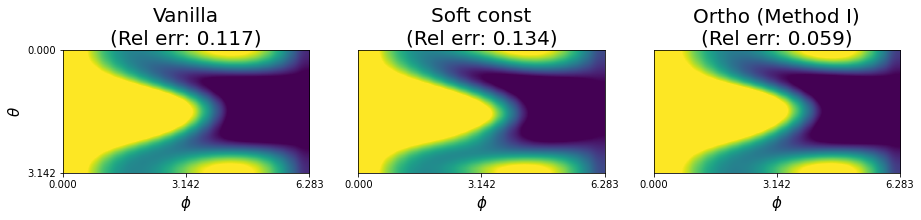

In [41]:
data_idx=452
fig=plt.figure(figsize=(15,3))

plot_name=["Vanilla", "Soft const", r"Ortho (Method I)"]

ax=plt.subplot(1,2,1)
ax.set_title(r"Input $f(\phi,\theta)$", fontsize=20)
im=ax.imshow(test_data_f[data_idx].reshape(integration_order*2,integration_order), vmin=0.03, vmax=0.16, extent=(0,2*np.pi,np.pi,0), origin='lower', cmap='OrRd', interpolation='gaussian')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
# cbaxes = fig.add_axes([0.05, 0.23, 0.01, 0.5])  # This is the position for the colorbar
# fig.colorbar(im, cax = cbaxes)
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_ylabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

ax=plt.subplot(1,2,2)
ax.set_title(r"Output $Q(\phi,\theta)$", fontsize=20)
im=ax.imshow(test_data_Q[data_idx].reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower', interpolation='gaussian')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)

ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])
plt.savefig('S2_profile_up.png', dpi=100, format='png',bbox_inches='tight')

fig=plt.figure(figsize=(15,3))
for plot_idx, idx in enumerate([0,2,3]):
    ax=plt.subplot(1,3,plot_idx+1)
    prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
    im=ax.imshow(prediction.reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower', interpolation='gaussian')
    if plot_idx==0:
        ax.set_ylabel(r'$\theta$',fontsize=15)
        ax.set_yticks([0,np.pi])
    else:
        ax.set_yticks([])
    ax.set_xlabel(r'$\phi$',fontsize=15)
    ax.set_xticks([0,np.pi,2*np.pi])
    
    error=rel_L2_error(prediction, test_data_Q[data_idx])
    ax.set_title("{}\n(Rel err: {:.3f})".format(plot_name[plot_idx],error), fontsize=20)
plt.savefig('S2_profile_down.png', dpi=100, format='png',bbox_inches='tight')
plt.show()

## 4) 3D case with g=0.9

In [42]:
dimension=3
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    'HG_09_wo_bias',
    'HG_09_w_bias',
    'HG_09_soft_lamb01',
    'HG_09_hard_gram',
    'HG_09_hard_special'
]

In [43]:
args=torch.load(f'results/{dimension}D/'+'entropy_HG/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [44]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_'+str(gparams['aniso_param'])+'_test_data.npz')


train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
aniso_param=gparams['aniso_param']
if dimension==1:
    Q = CollisionOperatorHG1D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperatorHG3D(integration_order, aniso_param)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

Volume is 1.0


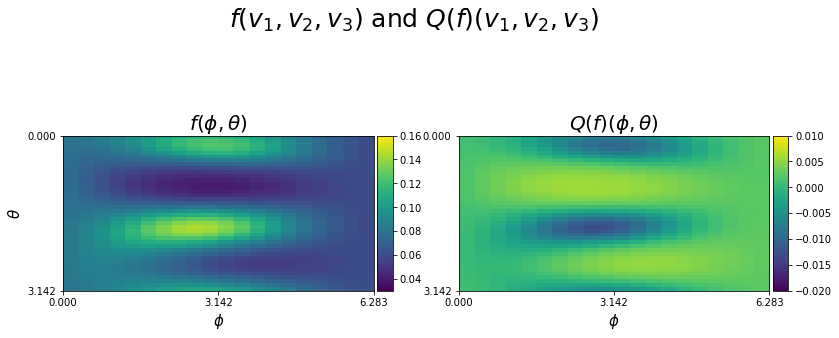

In [45]:
idx=np.random.randint(train_data_f.shape[0])

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig=plt.figure(figsize=(13,6))
plt.suptitle(r'$f(v_1,v_2,v_3)$ and $Q(f)(v_1,v_2,v_3)$', fontsize=25)
ax=plt.subplot(1,2,1)
ax.set_title(r'$f(\phi,\theta)$', fontsize=20)
im=ax.imshow(train_data_f[idx].reshape(integration_order*2,integration_order), vmin=0.03, vmax=0.16, extent=(0,2*np.pi,np.pi,0), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_ylabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

ax=plt.subplot(1,2,2)
ax.set_title(r'$Q(f)(\phi,\theta)$', fontsize=20)
im=ax.imshow(train_data_Q[idx].reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [46]:
print(torch.max(train_data_f),torch.min(train_data_f))

tensor(0.1699) tensor(0.0323)


In [47]:
print(torch.max(train_data_Q),torch.min(train_data_Q))

tensor(0.0069) tensor(-0.0179)


In [48]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

8900
tensor(0.2020)
8400
tensor(0.2051)
5400
tensor(0.3234)
7300
tensor(0.1453)
8000
tensor(0.1950)


In [49]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

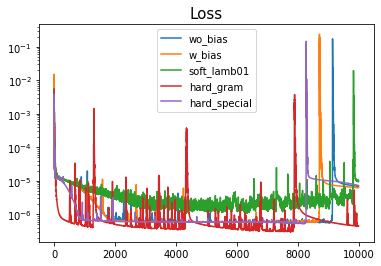

In [50]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

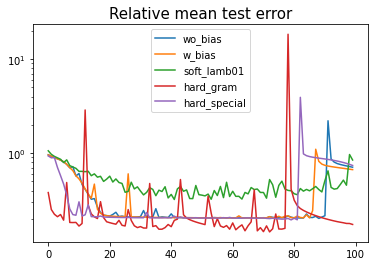

In [51]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [52]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

In [53]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

164
wo_bias      test error=0.2020, Mean $\int Qdv$=7.58E-04
(sample) test error=0.2275
w_bias       test error=0.2051, Mean $\int Qdv$=6.75E-04
(sample) test error=0.2309
soft_lamb01  test error=0.3234, Mean $\int Qdv$=5.38E-03
(sample) test error=0.3612
hard_gram    test error=0.1453, Mean $\int Qdv$=1.51E-08
(sample) test error=0.1856
hard_special test error=0.1950, Mean $\int Qdv$=1.74E-08
(sample) test error=0.2104


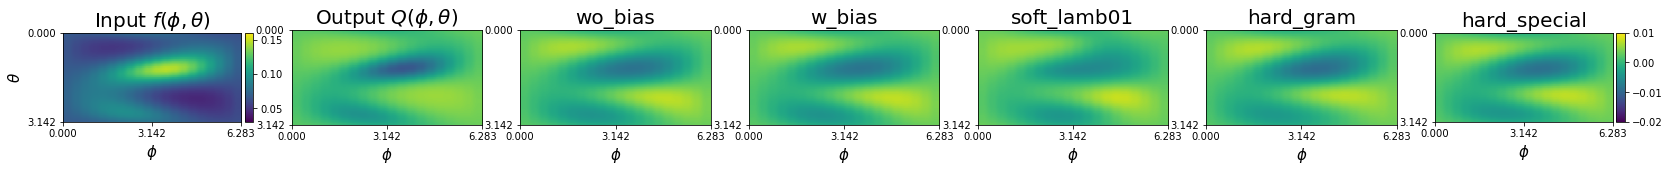

In [54]:
data_idx=np.random.randint(test_data_f.shape[0])
print(data_idx)
plt.figure(figsize=(28,5))

ax=plt.subplot(1,7,1)
ax.set_title(r"Input $f(\phi,\theta)$", fontsize=20)
im=ax.imshow(test_data_f[data_idx].reshape(integration_order*2,integration_order), vmin=0.03, vmax=0.16, extent=(0,2*np.pi,np.pi,0), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_ylabel(r'$\theta$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

ax=plt.subplot(1,7,2)
ax.set_title(r"Output $Q(\phi,\theta)$", fontsize=20)
im=ax.imshow(test_data_Q[data_idx].reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower')
ax.set_xlabel(r'$\phi$',fontsize=15)
ax.set_xticks([0,np.pi,2*np.pi])
ax.set_yticks([0,np.pi])

for idx in range(len(models)):
    ax=plt.subplot(1,7,idx+2+1)
    prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
    ax.set_title("{}".format(names[idx]), fontsize=20)
    im=ax.imshow(prediction.reshape(integration_order*2,integration_order), vmin=-0.02, vmax=0.01, extent=(0,2*np.pi,np.pi,0), origin='lower')
    ax.set_xlabel(r'$\phi$',fontsize=15)
    ax.set_xticks([0,np.pi,2*np.pi])
    ax.set_yticks([0,np.pi])
    prediction_all=models[idx](test_data_f.unsqueeze(1).cuda(), grid).squeeze().detach().cpu()
    all_error=rel_L2_error(prediction_all, test_data_Q).mean()
    all_Qdv=torch.mean(torch.abs(torch.sum(prediction_all*quad_w.detach().cpu(), axis=-1)))
    print(r"{:12s} test error={:.4f}, Mean $\int Qdv$={:.2E}".format(names[idx],all_error, all_Qdv))
    
    print("(sample) test error={:.4f}".format(rel_L2_error(prediction, test_data_Q[data_idx])))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()